## Optimization

This section covers some budget optimization strategy by leveraging a fitted MMM.

In [31]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning import TargetMaximizer, calculate_marginal_cost
from karpiu.explainability import Attributor

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 50)

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Bring back the fitted model from previous `Quickstart` section.

In [19]:
with open ('./resource/model.pkl', 'rb') as f:
    mmm = pickle.load(f)

In [107]:
budget_start = pd.to_datetime('2021-01-01')
budget_end = pd.to_datetime('2021-01-31')
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

spend_scaler = 1e3
response_scaler = 1e3

In [108]:
# steal this code to get all the matrices in the background
# and also report average cost of acq
attr_obj = Attributor(mmm, attr_regressors=optim_channels, start=budget_start, end=budget_end)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()
tot_attr_df = spend_attr_df[optim_channels].apply(np.sum, axis=0)
tot_spend_df = spend_df[optim_channels].apply(np.sum, axis=0)
avg_cost_df = tot_spend_df / tot_attr_df
avg_cost_df = pd.DataFrame(avg_cost_df)
avg_cost_df.index = avg_cost_df.index.rename("regressor")
avg_cost_df = avg_cost_df.rename(columns={0: "cac"})

# more data massage
# 1e4 is a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of 
# post optimization metrics
tot_spend_df = tot_spend_df / spend_scaler
tot_spend_df = pd.DataFrame(tot_spend_df)
tot_spend_df.index = tot_spend_df.index.rename("regressor")
tot_spend_df = tot_spend_df.rename(columns={0: "pre_opt_spend"})

In [109]:
mcac_df = calculate_marginal_cost(
    mmm,
    channels=optim_channels, 
    spend_start=budget_start, 
    spend_end=budget_end, 
)

In [110]:
pre_opt_report = pd.concat([avg_cost_df, mcac_df, tot_spend_df], axis=1, keys='regressor')
pre_opt_report.columns = ['pre-opt-cac', 'pre-opt-mcac', 'pre-opt-spend']
pre_opt_report

,pre-opt-cac,pre-opt-mcac,pre-opt-spend
regressor,,,
promo,51.46756,67.84067,41.01600
radio,69.65582,92.93477,131.89400
search,42.05950,44.49833,17.77200
social,55.91181,75.30311,81.93300
tv,221.78400,281.59104,225.00900


In [114]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels, 
)
optim_spend_df = maximizer.optimize(maxiter=500)

INFO:karpiu-planning:Optimizing channels is sorted. They are now : ['promo', 'radio', 'search', 'social', 'tv']


Optimization terminated successfully    (Exit mode 0)
            Current function value: -301.45620348568633
            Iterations: 129
            Function evaluations: 21329
            Gradient evaluations: 129


In [115]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [116]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(optim_spend_matrix.sum()))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 497624
Total Budget: 497624


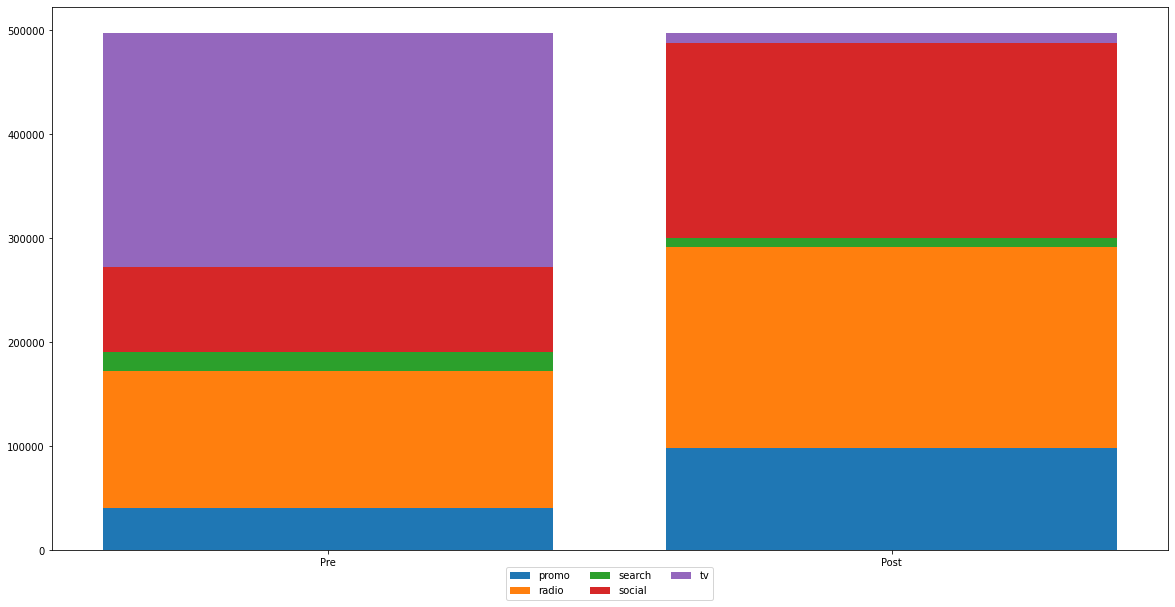

In [117]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=['Pre', 'Post'], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.10), ncol=math.ceil(len(optim_channels)/2));

In [118]:
post_mcac_df = calculate_marginal_cost(
    mmm,
    channels=mmm.get_spend_cols(), 
    spend_start=budget_start, 
    spend_end=budget_end, 
    spend_df=optim_spend_df,
)

In [119]:
attr_obj = Attributor(mmm, df=optim_spend_df, attr_regressors=optim_channels, start=budget_start, end=budget_end)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()
optim_tot_attr_df = spend_attr_df[optim_channels].apply(np.sum, axis=0)
optim_tot_spend_df = spend_df[optim_channels].apply(np.sum, axis=0)
post_avg_cost_df = optim_tot_spend_df / optim_tot_attr_df
post_avg_cost_df = pd.DataFrame(post_avg_cost_df)
post_avg_cost_df = post_avg_cost_df.rename(columns={0: "post-opt-cac"})

# more data massage
optim_tot_spend_df = optim_tot_spend_df / spend_scaler
optim_tot_spend_df = pd.DataFrame(optim_tot_spend_df)
optim_tot_spend_df.index = optim_tot_spend_df.index.rename("regressor")
optim_tot_spend_df = optim_tot_spend_df.rename(columns={0: "post-opt-spend"})

In [120]:
post_opt_report = pd.concat([post_avg_cost_df, post_mcac_df, optim_tot_spend_df], axis=1)
post_opt_report.columns = ['post-opt-cac', 'post-opt-mcac', 'post-opt-spend']
post_opt_report

,post-opt-cac,post-opt-mcac,post-opt-spend
promo,65.36687,93.56233,98.45787
radio,81.16962,112.00480,193.47626
search,32.53022,36.62052,8.02722
social,76.84782,110.10864,187.66080
tv,152.39145,173.02817,10.00185


In [121]:

opt_report = pd.concat([pre_opt_report, post_opt_report], axis=1)
opt_report = opt_report[[
    "pre-opt-cac", "post-opt-cac", "pre-opt-mcac",
    "post-opt-mcac", "pre-opt-spend", "post-opt-spend"]
]
opt_report

,pre-opt-cac,post-opt-cac,pre-opt-mcac,post-opt-mcac,pre-opt-spend,post-opt-spend
promo,51.46756,65.36687,67.84067,93.56233,41.01600,98.45787
radio,69.65582,81.16962,92.93477,112.00480,131.89400,193.47626
search,42.05950,32.53022,44.49833,36.62052,17.77200,8.02722
social,55.91181,76.84782,75.30311,110.10864,81.93300,187.66080
tv,221.78400,152.39145,281.59104,173.02817,225.00900,10.00185
